# Data processing for Olive groves

## Spatial projections of suitable area for all olive varieties in southern Spain

Data processing for Fig. 4 and SI2 of [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0048969719361571).

### **Abstract**

World olive production is based on the cultivation of different varieties that respond differently to abiotic factors. Climate change may affect the area of land suitable for olive cultivation and change production levels, thus caus- ing serious damage to this economically-relevant and highly-productive olive grove agroecosystem. In Mediter- ranean regions such as Andalusia, one of the main areas of olive production, the effect of climate change seems threatening. Thus, our main aims are: (1) to examine the abiotic factors that characterise the current cultivated locations and predict the current and potential distribution of these locations; (2) to evaluate the effect of climate change (based on regional scenarios) on the future environmental suitability of each olive variety; and (3) to an- alyse the expected alteration in the annual olive production. We used the seven most-productive olive varieties in Andalusia and the wild olive species to develop Species Distribution Models (SDMs), coupled with soil prop- erties, geomorphology, water balance and (bio-)climatic predictors at a fine scale. We also derived future climate projections to assess the effect of climate change on the environmental suitability and productivity of each olive variety. 

**Olive varieties**

Among the long list of olive varieties which are currently cultivated in Andalusia, we selected those catalogued as “principal” and that are the most used in Andalusian olive groves in rain-fed regimes (Rubio de Casas et al., 2002), namely: Hojiblanca (Hj), Lechín de Sevilla (Lch), Manzanilla de Sevilla (Mnz), Nevadillo negro (Nvd), Picudo (Pcd), Picual (Pcl) and Verdial de Huévar (Vrd). We also used the wild olive tree (Acebuche, Oe), closely related to the domesticated olive tree. Two varieties stand out for their importance in terms of area in An- dalusia: Picual, which represents about 60% of the olive groves, and Hojiblanca, with around 20%.


| Target                              | Code   | Main features                                                | Area (km2)        |
|-------------------------------------|--------|--------------------------------------------------------------|-------------------|
|Acebuche                             |Oe      |Wild species of reference                                     | 2161              |
|Hojiblanca                           |Hj      |Very-frequent olive-tree variety cultivated in plant nurseries| 7868              |
|Lechín de Sevilla                    |Lch     |Frequent olive-tree variety in plant nurseries                | 3221              |
|Manzanilla de Sevilla                |Mnz     |Frequent olive-tree variety in plant nurseries                | 2654              |
|Nevadillo negro                      |Nvd     |Traditional olive-tree variety                                | 1114              |
|Picudo                               |Pcd     |Traditional olive-tree variety                                | 2459              |
|Picual                               |Pcl     |Very-frequent olive-tree variety cultivated in plant nurseries| 18,677            |         
|Verdial de Huévar                    |Vrd     |Traditional olive-tree variety                                | 865               |



**Regional climate projections for Andalusia**

To understand the future distribution and assess the environmental suitability of each olive variety, we used the Local Scenarios of Climate Change of Andalusia (ELCCA) (URL: [http://www.juntadeandalucia.es/ medioambiente/site/rediam](https://www.juntadeandalucia.es/medioambiente/portal/datos-ambientales?categoryVal=)). These regional climate change scenarios were specifically developed for the Andalusia region to represent the changes expected in the climate in the coming decades, according to studies carried out on a planetary scale. The scenarios were produced from the Third Generation Coupled Global Climate Model (MCGs; CNCM3), for a balance across all sources (A1b; IV IPCC Report), for three periods: `2011–2040` (“Proj-2040”), `2041–2070` (“Proj-2070”) and `2071–2100` (“Proj-2100”). 
The baseline (current) climatic data used to run the models comprised the average values for the interval `1961–2000`. From these simulations, (bio-)climatic variables (such as monthly precipitation and temperature) were derived. We then calcu- lated aggregation statistics (the mean as well as the 5%, 50% and 95% quantiles) for all the climatic variables, to assess projected changes in the study region.


## Climate change projections for olive yields in the Mediterranean Basin

Data processing for Fig. 2-4 [this paper](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/joc.6237).

### **Abstract**

The olive tree is one of the most important crops in the Mediterranean basin. Given
the strong climatic influence on olive trees, it becomes imperative to assess climate
change impacts on this crop. Herein, these impacts were innovatively assessed, based
on an ensemble of state-of-the-art climate models, future scenarios and dynamic crop
models. The recent-past (`1989–2005`) and future (`2041–2070`, RCP4.5 and RCP8.5)
olive growing season length (GSL), yield, growing season temperature (GST) and pre-
cipitation (GSP), potential (ETP) and actual (ETA) evapotranspiration, water demand
(WD) and water productivity (WP) were assessed over Southern Europe

# Setup
## Library import
We import all the required Python libraries

In [4]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import box
from tqdm import tqdm
from osgeo import gdal
import gdal2tiles
import ipyleaflet as ipyl
from dotenv import load_dotenv
import glob
from google.cloud import storage
from google.oauth2 import service_account
from typing import List

In [8]:
import utils  

## Utils
**upload_local_directory_to_gcs**

In [9]:
def upload_local_directory_to_gcs(bucket_name, local_path, destination_blob_path):
    """Uploads a directory to the bucket."""
    
    credentials_dict = {
          "type": "service_account",
          "project_id": os.getenv("PROJECT_ID"),
         "private_key_id": os.getenv("PRIVATE_KEY_ID"),
          "private_key":os.getenv("PRIVATE_KEY"),
         "client_email": os.getenv("CLIENT_EMAIL"),
          "token_uri":os.getenv("TOKEN_URI"),   
    } 
    

    credentials = service_account.Credentials.from_service_account_info(credentials_dict)
    storage_client = storage.Client(project='project_id', credentials=credentials)
    
    bucket = storage_client.bucket(bucket_name)
    rel_paths = glob.glob(local_path + '/**', recursive=True)

    for local_file in rel_paths:
        remote_path = f'{destination_blob_path}{"/".join(local_file.split(os.sep)[len(local_path.split(os.sep))-1:])}'
        if os.path.isfile(local_file):
            blob = bucket.blob(remote_path)
            print(
                "File {} uploaded to {}.".format(
                    local_file, remote_path
                )
            )
            blob.upload_from_filename(local_file)

**set_bucket_public_iam**

In [10]:
def set_bucket_public_iam(
    bucket_name: str = "your-bucket-name",
    members: List[str] = ["allUsers"],
):
    """Set a public IAM Policy to bucket"""
    # bucket_name = "your-bucket-name"

    credentials_dict = {
          "type": "service_account",
          "project_id": os.getenv("PROJECT_ID"),
         "private_key_id": os.getenv("PRIVATE_KEY_ID"),
          "private_key":os.getenv("PRIVATE_KEY"),
         "client_email": os.getenv("CLIENT_EMAIL"),
          "token_uri":os.getenv("TOKEN_URI"),   
    } 
    

    credentials = service_account.Credentials.from_service_account_info(credentials_dict)
    storage_client = storage.Client(project='project_id', credentials=credentials)
    bucket = storage_client.bucket(bucket_name)

    policy = bucket.get_iam_policy(requested_policy_version=3)
    policy.bindings.append(
        {"role": "roles/storage.objectViewer", "members": members}
    )

    bucket.set_iam_policy(policy)

    print("Bucket {} is now publicly readable".format(bucket.name))

# Data import
## Spatial projections of suitable area for all olive varieties in southern Spain
### Vector data
**Read data**

In [134]:
df_all = pd.read_csv('../../datasets/raw/crops/olivar/Arenas_Castro/EnsSuitability_AllVarieties_Q95_woutNA.csv')
df_all.head()

,x,y,current.Q95,proj2040.Q95,proj2070.Q95,proj2100.Q95
0,-5.177276,38.721888,267.299988,299.450012,359.649994,371.750000
1,-5.067276,38.721888,538.900024,540.000000,533.599976,523.750000
2,-5.057276,38.721888,192.949997,339.149994,366.899994,389.200012
3,-5.047276,38.721888,204.800003,366.500000,384.250000,387.200012
4,-5.037276,38.721888,447.000000,512.400024,513.000000,499.750000


**Create grid**

In [ ]:
gdf_all = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.x, df_all.y))
gdf_all = gdf_all.set_crs("EPSG:4326")

In [ ]:
# total area for the grid
xmin, ymin, xmax, ymax= gdf_all.total_bounds
# how many cells across and down
n_cells=gdf_all['x'].nunique()
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "EPSG:4326"
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(box(x0+cell_size*0.5, y0-cell_size*0.5, x1+cell_size*0.5, y1-cell_size*0.5)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#cell.plot(ax=ax, facecolor="none", edgecolor='grey')
gdf_all.plot(ax=ax, column='current.Q95', markersize=8)
#ax.set_ylim([37.5,38]);
#ax.set_xlim([-5,-4.5]);

**Intersect points with grid**

In [ ]:
polygons = []
sindex = cell.sindex
# Iterate over the geometries
for n, geometry in enumerate(tqdm(gdf_all.geometry)):

    # Find approximate matches with r-tree
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    possible_matches = cell.iloc[possible_matches_index]
    # Find precise matches with r-tree
    polygons.append(possible_matches[possible_matches.intersects(geometry)]['geometry'].iloc[0])

gdf_all['geometry'] = polygons

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#cell.plot(ax=ax, facecolor="none", edgecolor='grey')
gdf_all.plot(ax=ax, column='current.Q95')
#ax.set_ylim([37.5,38]);
#ax.set_xlim([-5,-4.5]);

### Raster data
**Read data**

In [146]:
years_file = {'1961–2000': 'EnsSuitability_AllVarieties_Q95_Present.tif',
             '2011–2040': 'EnsSuitability_AllVarieties_Q95_Proj2040.tif',
             '2041–2070': 'EnsSuitability_AllVarieties_Q95_Proj2070.tif',
             '2071–2100': 'EnsSuitability_AllVarieties_Q95_Proj2100.tif'}

for i, year in enumerate(years_file.keys()):

    # Read tiff
    xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}').squeeze().drop("band")
    
    # replace all values equal to -3.4e+38 with np.nan
    xda = xda.where(xda != list(xda.attrs['nodatavals'])[0]) 
        
    # add time and depth coordinates
    xda = xda.assign_coords({"time": year}).expand_dims(['time'])
    
    # convert to Dataset and concatenate by depth
    if year == '1961–2000':
        xds = xr.Dataset({'EnsSuitability_AllVarieties_Q95': xda}, attrs=xda.attrs)
    else:
        xds_time = xr.Dataset({'EnsSuitability_AllVarieties_Q95': xda}, attrs=xda.attrs)

        xds = xr.concat([xds, xds_time], dim='time')

/tmp/ipykernel_109/608946608.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}').squeeze().drop("band")
/tmp/ipykernel_109/608946608.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}').squeeze().drop("band")
/tmp/ipykernel_109/608946608.py:9: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  xda = xr.open_rasterio(f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_fi

In [142]:
xds

<xarray.Dataset>
Dimensions:                          (y: 274, x: 590, time: 4)
Coordinates:
  * y                                (y) float64 38.73 38.72 ... 36.01 36.0
  * x                                (x) float64 -7.517 -7.507 ... -1.637 -1.627
  * time                             (time) <U9 '1961–2000' ... '2071–2100'
Data variables:
    EnsSuitability_AllVarieties_Q95  (time, y, x) float32 nan nan ... nan nan
Attributes:
    transform:      (0.01, 0.0, -7.522276026, 0.0, -0.009999999999999981, 38....
    crs:            +init=epsg:4326
    res:            (0.01, 0.009999999999999981)
    is_tiled:       0
    nodatavals:     (-3.3999999521443642e+38,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

**Display data**

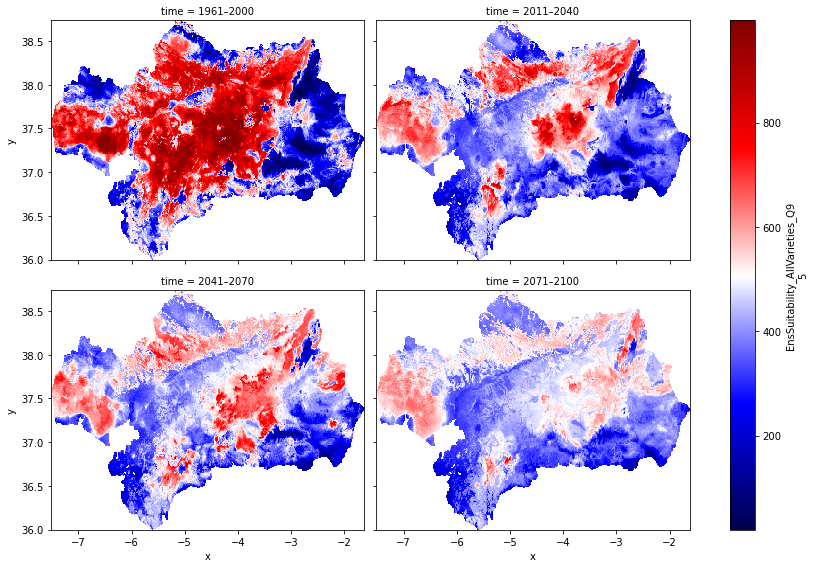

In [147]:
xds['EnsSuitability_AllVarieties_Q95'].plot(x="x", y="y", col="time", col_wrap=2, cmap='seismic', figsize=(12,8))

**Display data on map with `xarray-leaflet`**

In [138]:
import xarray_leaflet
import rioxarray
import ipyleaflet as ipyl

m = ipyl.Map()
l = xds['EnsSuitability_AllVarieties_Q95'].isel(time=3).leaflet.plot(m)
m.add_layer(l)
m

Url()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

#### **Generate tiles with [`gdal2tiles`](https://gdal.org/programs/gdal2tiles.html)**

**Transform Tiff to `uint8`**

In [19]:
years_file = {'1961_2000': 'EnsSuitability_AllVarieties_Q95_Present_RGB',
             '2011_2040': 'EnsSuitability_AllVarieties_Q95_Proj2040_RGB',
             '2041_2070': 'EnsSuitability_AllVarieties_Q95_Proj2070_RGB',
             '2071_2100': 'EnsSuitability_AllVarieties_Q95_Proj2100_RGB'}

for i, year in enumerate(years_file.keys()):
    input_file = f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}.tif'
    output_file = f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}_Byte.tif'

    #If dataset dtype isn't uint8 will need to transform
    #ensure there's as many -b as bands in the image (max 3)
    !gdal_translate \
        -ot Byte \
        -scale \
        -co tiled=yes \
        -co compress=deflate \
        -b 1 -b 2 -b 3\
        {input_file} {output_file}

    #in the second to last row, add -b1 -b2 -b3 if 3-band raster

Input file size is 613, 548
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 613, 548
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 613, 548
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 613, 548
0...10...20...30...40...50...60...70...80...90...100 - done.


**Convert black background to transparent**

In [20]:
for i, year in enumerate(years_file.keys()):
    input_file = f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}_Byte.tif'
    vrt_file = f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}_Byte.vrt'
    output_file = f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}_Byte_transparent.tif'

    !gdalbuildvrt -srcnodata "0 0 0" {vrt_file} {input_file}
    !gdal_translate {vrt_file} {output_file}

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 613, 548
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 613, 548
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 613, 548
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 613, 548
0...10...20...30...40...50...60...70...80...90...100 - done.


**Create tiles**

In [12]:
def create_tiles(source_path, destination_path):
    """
    Method to generate tiles at different zoom levels using gdal2tiles library.
    Args:
    source_path : path for the source file which needs to be tiled
    destination_path : path for the output directory where the tiles will be generated
    """
    options = {'zoom': '10',
               'nb_processes': 48,
               'tile_size': 256,
               'srs':'EPSG:4326'}
    gdal2tiles.generate_tiles(source_path, destination_path,
     **options)

[`--xyz`](https://gdal.org/programs/gdal2tiles.html#cmdoption-gdal2tiles-xyz) option is required to generate XYZ tiles ([OSM Slippy Map standard](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames)) instead of [TMS](https://en.wikipedia.org/wiki/Tile_Map_Service)

In [21]:
for i, year in enumerate(years_file.keys()):

    source_path = f'../../datasets/raw/crops/olivar/Arenas_Castro/{years_file[year]}_Byte_transparent.tif'
    destination_path = f'../../datasets/processed/RasterTiles/olivar/Arenas_Castro/{year}/'

    !gdal2tiles.py --xyz --zoom=0-10 --processes=48 --tilesize=256 --s_srs='EPSG:4326' {source_path} {destination_path}

Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100


Change tile permissions

In [22]:
for i, year in enumerate(years_file.keys()):
    !find ../../datasets/processed/RasterTiles/olivar/Arenas_Castro/$year -type f -exec chmod 777 {} \;

**Display tiles**

In [16]:
center = (38, -5)
m = ipyl.Map(center=(center), zoom=6)

m.add_layer(ipyl.LocalTileLayer(path='/tree/work/datasets/processed/RasterTiles/olivar/Arenas_Castro/1961_2000/{z}/{x}/{y}.png'))

control = ipyl.LayersControl(position='topright')
m.add_control(control)
m.add_control(ipyl.FullScreenControl())
m

Map(center=[38, -5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

#### **Upload files to GCS**

In [ ]:
load_dotenv()


bucket_name = 'ecf-agricultural-climate-impact'

for i, year in enumerate(years_file.keys()):
    print(year)
    local_path = f'../../datasets/processed/RasterTiles/olivar/Arenas_Castro/{year}/'
    destination_blob_path = f'RasterTiles/olivar/Arenas_Castro/{year}/'

    upload_local_directory_to_gcs(bucket_name, local_path, destination_blob_path)

**Make bucket  publicly readable**

In [ ]:
set_bucket_public_iam('ecf-agricultural-climate-impact', ["allUsers"])

**Display tiles**

In [25]:
center = (38, -5)
m = ipyl.Map(center=(center), zoom=6)

m.add_layer(ipyl.TileLayer(
    url='https://storage.googleapis.com/ecf-agricultural-climate-impact/RasterTiles/olivar/Arenas_Castro/1961_2000/{z}/{x}/{y}.png',
    layers='olivar',
    format='image/png',
    name='olivar',
    opacity=1
))

control = ipyl.LayersControl(position='topright')
m.add_control(control)
m.add_control(ipyl.FullScreenControl())
m

Map(center=[38, -5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

***
# Climate change projections for olive yields in the Mediterranean Basin
### Raster data
**Read data**

In [180]:
years_file = {'1989–2005': 'present.nc',
             '2041–2070': 'future_rcp85.nc'}

for i, year in enumerate(years_file.keys()):

    # Read tiff
    xds_tmp = xr.open_dataset(f'../../datasets/raw/crops/olivar/Fraga/{years_file[year]}', decode_coords="all")
        
    
    # convert to Dataset and concatenate by time
    if year == '1989–2005':
        xds = xds_tmp
    else:
        xds = xr.concat([xds, xds_tmp], dim='time')

In [181]:
xds

<xarray.Dataset>
Dimensions:  (lon: 376, lat: 200, time: 2)
Coordinates:
  * lon      (lon) float64 -11.94 -11.81 -11.69 -11.56 ... 34.69 34.81 34.94
  * lat      (lat) float64 35.06 35.19 35.31 35.44 ... 59.56 59.69 59.81 59.94
  * time     (time) float64 17.0 30.0
Data variables:
    yield    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.5.0 (http://code.zmaw.de/p...
    Conventions:  CF-1.0
    history:      Wed Nov 24 15:03:28 2021: cdo selvar,yield eval_mean.nc pre...
    CDO:          Climate Data Operators version 1.5.1rc3 (http://code.zmaw.d...

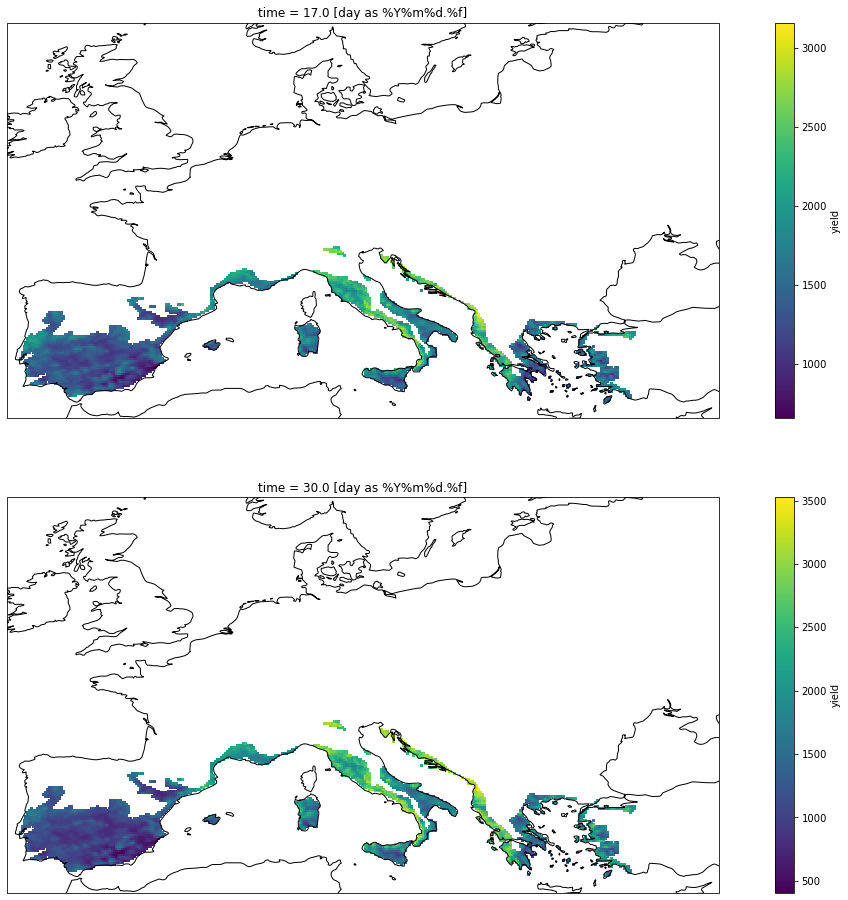

In [182]:
fig = plt.figure(figsize=(20,16))

ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())

ax1.set_global()
xds['yield'].isel(time=0).plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax1.coastlines()
ax1.set_ylim([35,60]);
ax1.set_xlim([-10,35]);

ax2.set_global()
xds['yield'].isel(time=1).plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([35,60]);
ax2.set_xlim([-10,35]);

**Clip array with spain**

In [183]:
## Spain
spain = gpd.read_file('../../datasets/processed/spain.geojson', driver='GeoJSON')

In [184]:
for ns, scenario in enumerate(['rcp45', 'rcp85']):

    years_file = {'1989–2005': 'present.nc',
                  '2041–2070': f'future_{scenario}.nc'}
    
    for i, year in enumerate(years_file.keys()):
    
        # Read tiff
        xds_tmp = xr.open_dataset(f'../../datasets/raw/crops/olivar/Fraga/{years_file[year]}', decode_coords="all")
        
        # Clip
        xds_tmp.rio.write_crs("EPSG:4326", inplace=True)    
        xds_tmp = xds_tmp.rio.clip(spain.geometry.values, spain.crs)
        
        xds_tmp = xds_tmp.assign_coords({'time': [year]})
        xds_tmp = xds_tmp.assign_coords({"scenario": scenario})
        
        # convert to Dataset and concatenate by time
        if year == '1989–2005':
            xds_clipped = xds_tmp
        else:
            xds_clipped = xr.concat([xds_clipped, xds_tmp], dim='time')
        
    if ns == 0:
        ds_clipped = xds_clipped.copy()
    else:
        ds_clipped = xr.concat([ds_clipped, xds_clipped.copy()], dim='scenario')
        
ds_clipped = ds_clipped.drop_vars('spatial_ref')

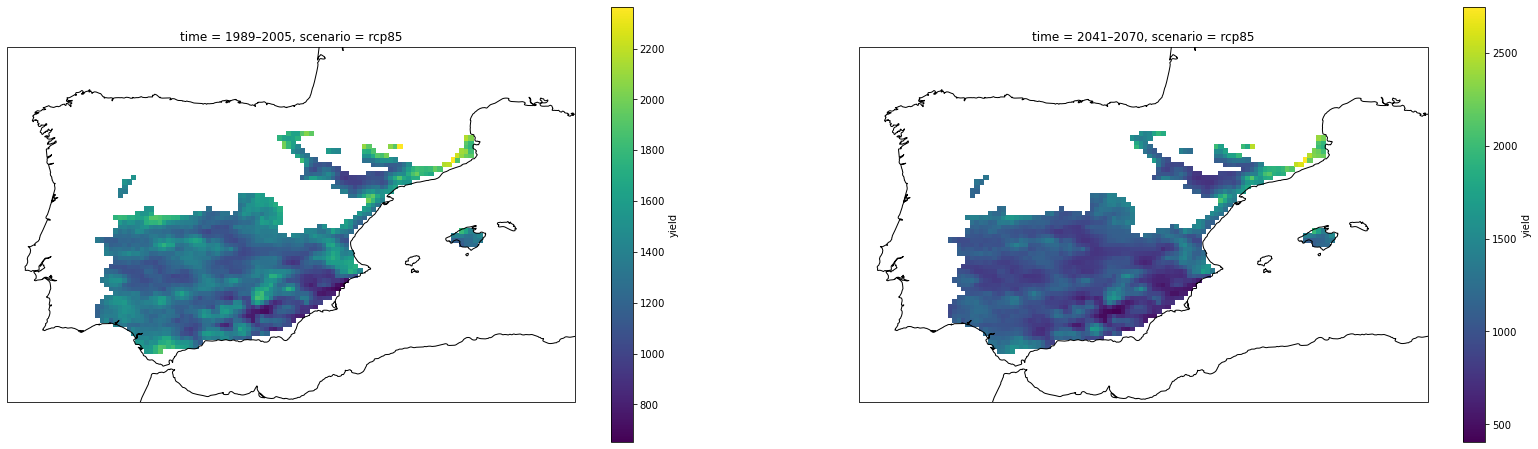

In [185]:
fig = plt.figure(figsize=(28,8))

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

ax1.set_global()
ds_clipped['yield'].isel(time=0).sel(scenario='rcp85').plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax1.coastlines()
ax1.set_ylim([35,45]);
ax1.set_xlim([-10,6]);

ax2.set_global()
ds_clipped['yield'].isel(time=1).sel(scenario='rcp85').plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([35,45]);
ax2.set_xlim([-10,6]);

**Yield change**

In [186]:
attrs =  ds_clipped.attrs

da = (ds_clipped['yield'].isel(time=1) - ds_clipped['yield'].isel(time=0))/ds_clipped['yield'].isel(time=0) *100
da = da.rename('yield_change_per')
da = da.assign_coords({'time': ds_clipped.time[1]})

ds_change = da.to_dataset().assign_attrs(attrs).expand_dims("time").transpose('time', 'lat', 'lon', 'scenario')

In [187]:
ds_change

<xarray.Dataset>
Dimensions:           (lat: 62, lon: 108, scenario: 2, time: 1)
Coordinates:
  * lat               (lat) float64 36.06 36.19 36.31 ... 43.44 43.56 43.69
  * lon               (lon) float64 -9.188 -9.062 -8.938 ... 3.938 4.062 4.188
  * scenario          (scenario) <U5 'rcp45' 'rcp85'
  * time              (time) <U9 '2041–2070'
Data variables:
    yield_change_per  (time, lat, lon, scenario) float64 nan nan nan ... nan nan
Attributes:
    CDI:          Climate Data Interface version 1.5.0 (http://code.zmaw.de/p...
    Conventions:  CF-1.0
    history:      Wed Nov 24 15:03:28 2021: cdo selvar,yield eval_mean.nc pre...
    CDO:          Climate Data Operators version 1.5.1rc3 (http://code.zmaw.d...

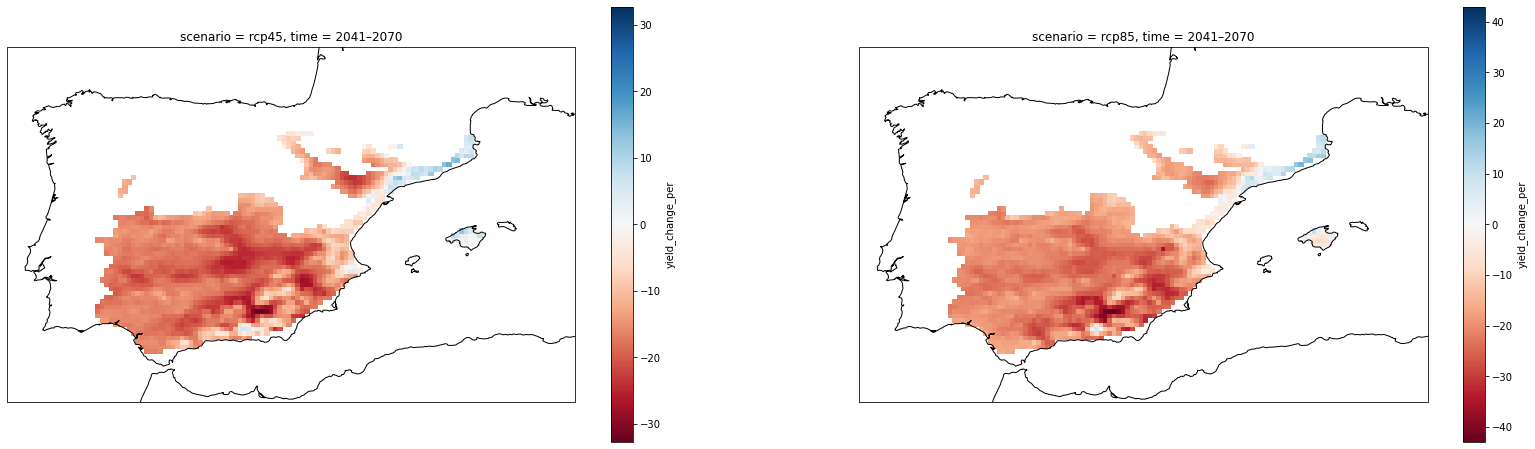

In [188]:
fig = plt.figure(figsize=(28,8))

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())

ax1.set_global()
ds_change['yield_change_per'].isel(time=0).sel(scenario='rcp45').plot.pcolormesh(ax=ax1, cmap='RdBu', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax1.coastlines()
ax1.set_ylim([35,45]);
ax1.set_xlim([-10,6]);

ax2.set_global()
ds_change['yield_change_per'].isel(time=0).sel(scenario='rcp85').plot.pcolormesh(ax=ax2, cmap='RdBu', transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=True)
ax2.coastlines()
ax2.set_ylim([35,45]);
ax2.set_xlim([-10,6]);

### Vector data
**Read data**

In [230]:
comunidades = gpd.read_file(f'../../datasets/processed/comunidades.geojson')
provincias = gpd.read_file('../../datasets/processed/provincias.geojson')  
comarcas_agr = gpd.read_file(f'../../datasets/processed/comarcas_agrarias.geojson')
municipios = gpd.read_file('../../datasets/processed/municipios.geojson')  

In [233]:
gdf_vectors = {"Comunidades autonomas": comunidades,
    "Provincias": provincias,
    "Comarcas agrarias": comarcas_agr,
    "Municipios": municipios}

## Zonal statistics
### Rasterize vector data
**Create the data mask by rasterizing the vector data**

In [234]:
ds_name = 'Olivar'

da_masks = {}
ids_not_in_masks = {}

da_mask = {}
ids_not_in_mask = {}
for gdf_name, gdf in gdf_vectors.items():
    print(gdf_name)
    #Create the data mask by rasterizing the vector data
    gdf = gdf.reset_index(drop=True).copy()
    da_mask[gdf_name], ids_not_in_mask[gdf_name] = utils.create_ds_mask(gdf.copy(), ds_change, name=gdf_name.lower().replace(' ', '_'), lon_name='lon', lat_name='lat')
        
da_masks[ds_name] = da_mask 
ids_not_in_masks[ds_name] = ids_not_in_mask

Comunidades autonomas
Number of indexes: 16
Number of geoms: 16


/opt/conda/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Number of ints in mask: 16
Provincias
Number of indexes: 48
Number of geoms: 48


/opt/conda/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Number of ints in mask: 48
Comarcas agrarias
Number of indexes: 346
Number of geoms: 346


/opt/conda/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Number of ints in mask: 337
Ints not in mask: [186 196 204 212 240 284 299 307 332]
Municipios
Number of indexes: 8115
Number of geoms: 8115


/opt/conda/lib/python3.8/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


Number of ints in mask: 2664
Ints not in mask: [   1    3    7 ... 8110 8111 8114]


### Compute mean values for each indicator and time 
****Add mask as a new variable into the xarray.Dataset****

In [235]:
masks = da_masks['Olivar']
for gdf_name, mask in masks.items():
    print(gdf_name)
    ds_change[gdf_name.lower().replace(' ', '_')] = mask

Comunidades autonomas
Provincias
Comarcas agrarias
Municipios


In [236]:
ds_change

<xarray.Dataset>
Dimensions:                (lat: 62, lon: 108, scenario: 2, time: 1)
Coordinates:
  * lat                    (lat) float64 36.06 36.19 36.31 ... 43.44 43.56 43.69
  * lon                    (lon) float64 -9.188 -9.062 -8.938 ... 4.062 4.188
  * scenario               (scenario) <U5 'rcp45' 'rcp85'
  * time                   (time) <U9 '2041–2070'
Data variables:
    yield_change_per       (time, lat, lon, scenario) float64 nan nan ... nan
    comarcas_agrarias      (lat, lon) float64 nan nan nan nan ... nan nan nan
    municipios             (lat, lon) float64 nan nan nan nan ... nan nan nan
    comunidades_autonomas  (lat, lon) float64 nan nan nan nan ... nan nan nan
    provincias             (lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.5.0 (http://code.zmaw.de/p...
    Conventions:  CF-1.0
    history:      Wed Nov 24 15:03:28 2021: cdo selvar,yield eval_mean.nc pre...
    CDO:          Climate Data Operators version 1.5.1rc3 (http://code.zmaw.d...

**Compute mean value over time**

In [237]:
indicator = 'yield_change_per'

gdf_indicators = gdf_vectors.copy()
for gdf_name, mask in masks.items():
    print(gdf_name)
    gdf = gdf_indicators[gdf_name]
    ds = ds_change.copy()
    for scenario in ds.scenario.data:
        print(scenario)
        mean_values = [] 
        for index in tqdm(ds[gdf_name.lower().replace(' ', '_')].attrs['id_ints']):
            mean_values.append(ds[indicator].sel(scenario=scenario).where(ds[gdf_name.lower().replace(' ', '_')] == index).mean(['lon', 'lat']).values)
        
        #Add values for geometries smaller than mean cell size 
        centroid_values = utils.get_centroid_values(gdf, ds, ds[indicator].sel(scenario=scenario), ids_not_in_masks[ds_name][gdf_name], logical_coordinates=False, lon_name='lon', lat_name='lat')
            
            
        df = pd.DataFrame({'index': list(ds[gdf_name.lower().replace(' ', '_')].attrs['id_ints']) + list(ids_not_in_masks[ds_name][gdf_name]),\
                          f'{indicator} ({scenario})': mean_values + centroid_values,
                          f'{indicator} ({scenario}) (time)': [list(ds.coords['time'].values)]*len(mean_values + centroid_values)})
        
        gdf = pd.merge(gdf.reset_index(), df, how = 'left', on = 'index').drop(columns='index')
    
    gdf_indicators[gdf_name] = gdf

Comunidades autonomas
rcp45


100%|██████████| 16/16 [00:00<00:00, 209.29it/s]


Adding values for geometries smaller than mean cell size:


0it [00:00, ?it/s]


rcp85


100%|██████████| 16/16 [00:00<00:00, 498.06it/s]


Adding values for geometries smaller than mean cell size:


0it [00:00, ?it/s]


Provincias
rcp45


100%|██████████| 48/48 [00:00<00:00, 491.02it/s]


Adding values for geometries smaller than mean cell size:


0it [00:00, ?it/s]


rcp85


100%|██████████| 48/48 [00:00<00:00, 449.88it/s]


Adding values for geometries smaller than mean cell size:


0it [00:00, ?it/s]


Comarcas agrarias
rcp45


100%|██████████| 337/337 [00:00<00:00, 491.73it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 9/9 [00:00<00:00, 2508.89it/s]


rcp85


100%|██████████| 337/337 [00:00<00:00, 509.39it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 9/9 [00:00<00:00, 2431.17it/s]


Municipios
rcp45


100%|██████████| 2664/2664 [00:04<00:00, 535.73it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 5451/5451 [00:01<00:00, 3204.34it/s]


rcp85


100%|██████████| 2664/2664 [00:04<00:00, 625.69it/s]


Adding values for geometries smaller than mean cell size:


100%|██████████| 5451/5451 [00:01<00:00, 3259.17it/s]


**Reorganice indicator table**

In [241]:
ds_name = 'Olivar'
ds = ds_change.copy()
gdf_ids = {'Comarcas agrarias': ['CO_CCAA', 'CO_PROVINC', 'CO_COMARCA'],
'Provincias': ['CO_CCAA', 'CO_PROVINC'],
'Comunidades autonomas': ['CO_CCAA'],
'Municipios': ['CODIGOINE']}

indicator_units = {'yield_change_per': '%'}

for gdf_name, gdf in gdf_indicators.items():
    print(gdf_name)
    df = pd.DataFrame(columns=gdf_ids[gdf_name] + ['dataset', 'indicator', 'scenario', 'value', 'year'])
    indicators = list(ds.keys())[:len(masks.keys())*-1]
    for indicator in indicators:
        print(indicator)
        for scenario in ds.scenario.data:
            print(scenario)
            df_tmp = gdf[gdf_ids[gdf_name] + [f'{indicator} ({scenario})', f'{indicator} ({scenario}) (time)']]
            df_tmp.rename(columns={f'{indicator} ({scenario})': 'value', f'{indicator} ({scenario}) (time)': 'year'}, inplace=True)
            df_tmp['dataset'] = ds_name
            df_tmp['indicator'] = indicator
            df_tmp['scenario'] = scenario
            
            # Convert list-like columns (values and years) elements to separate rows
            df_tmp_melt = df_tmp.drop(["year"], axis = 1).copy()
            
            df_tmp_melt = df_tmp_melt['value'].apply(pd.Series)\
            .merge(df_tmp_melt, right_index = True, left_index = True)\
            .drop(["value"], axis = 1)\
            .reset_index()\
            .melt(id_vars = gdf_ids[gdf_name] + ['index', 'dataset', 'indicator', 'scenario'], value_name = "value")\
            .sort_values(['index', 'variable'])\
            .drop(["index", 'variable'], axis = 1)
            
            df_tmp_melt['year'] = df_tmp['year'].iloc[0]*len(df_tmp)
            
            df = pd.concat([df, df_tmp_melt])
            
            df.reset_index(drop=True, inplace=True)
            
    # Add units
    df['unit'] = df['indicator'].apply(lambda x: indicator_units[x])   
    
    gdf_indicators[gdf_name] = df

Comunidades autonomas
yield_change_per
rcp45
rcp85
Provincias
yield_change_per
rcp45
rcp85
Comarcas agrarias
yield_change_per
rcp45
rcp85


/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_109/2231996938.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['dataset'] = ds_name
/tmp/ipykernel_109/2231996938.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

Municipios
yield_change_per
rcp45


/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_109/2231996938.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['dataset'] = ds_name
/tmp/ipykernel_109/2231996938.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

rcp85


/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/tmp/ipykernel_109/2231996938.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['dataset'] = ds_name
/tmp/ipykernel_109/2231996938.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

**Display output/input figures**

In [244]:
dataset = 'Olivar'
indicator = 'yield_change_per'
scenario = 'rcp85'
year = '2041–2070'
bbox = [-10, 35, 6, 45]

ds_rasters = {'Olivar': ds_change}

Comunidades autónomas

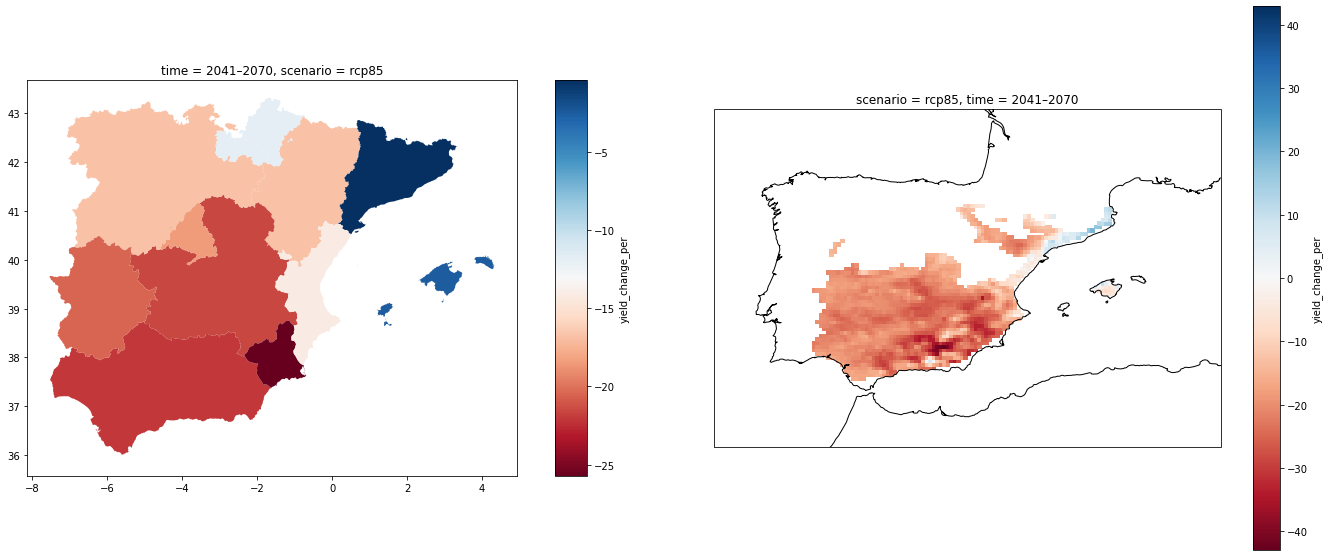

In [247]:
geometry = 'Comunidades autonomas'

utils.display_figures(gdf_indicators, gdf_vectors, gdf_ids, geometry, ds_rasters, dataset, indicator, scenario, year, bbox, cmap='RdBu')

Provincias

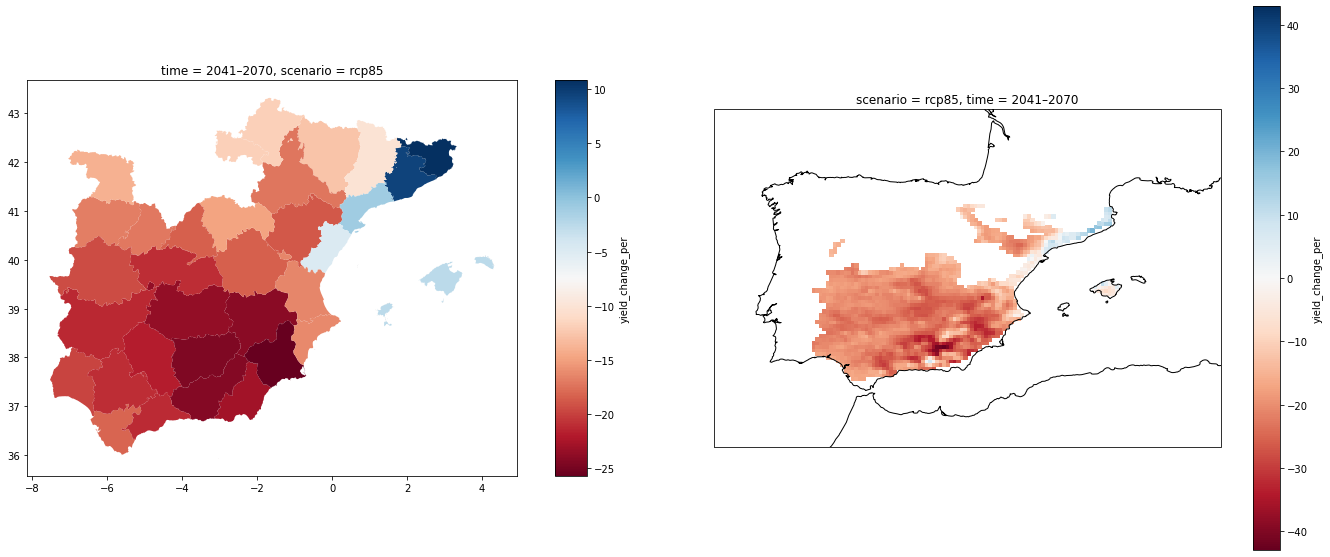

In [248]:
geometry = 'Provincias'

utils.display_figures(gdf_indicators, gdf_vectors, gdf_ids, geometry, ds_rasters, dataset, indicator, scenario, year, bbox, cmap='RdBu')

Comarcas agrarias

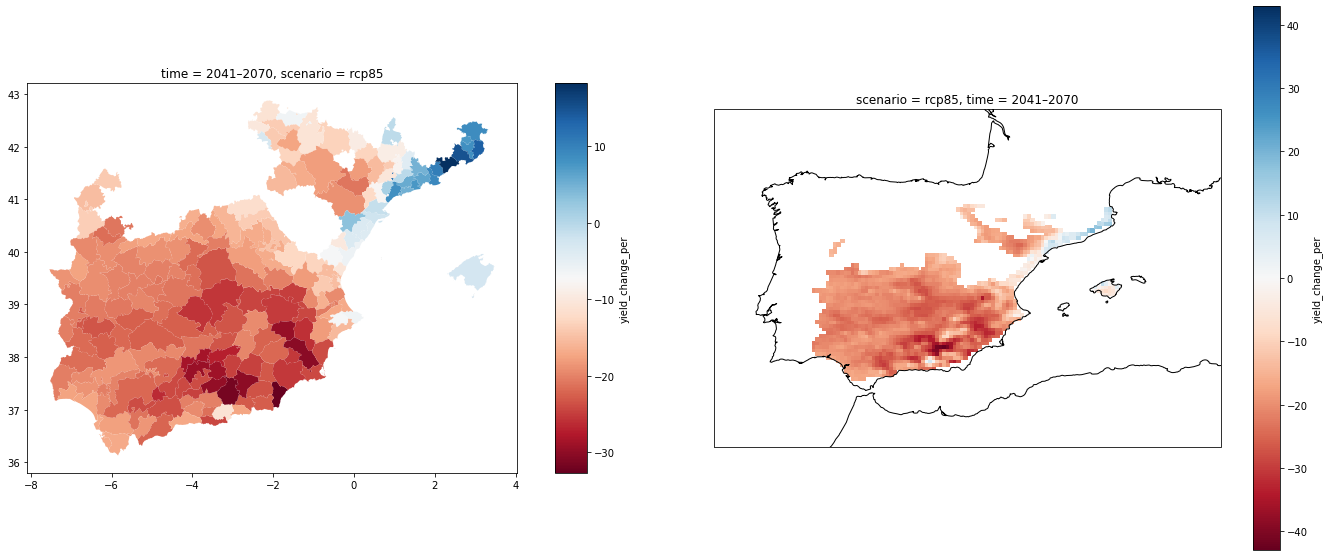

In [245]:
geometry = 'Comarcas agrarias'

utils.display_figures(gdf_indicators, gdf_vectors, gdf_ids, geometry, ds_rasters, dataset, indicator, scenario, year, bbox, cmap='RdBu')

Municipios

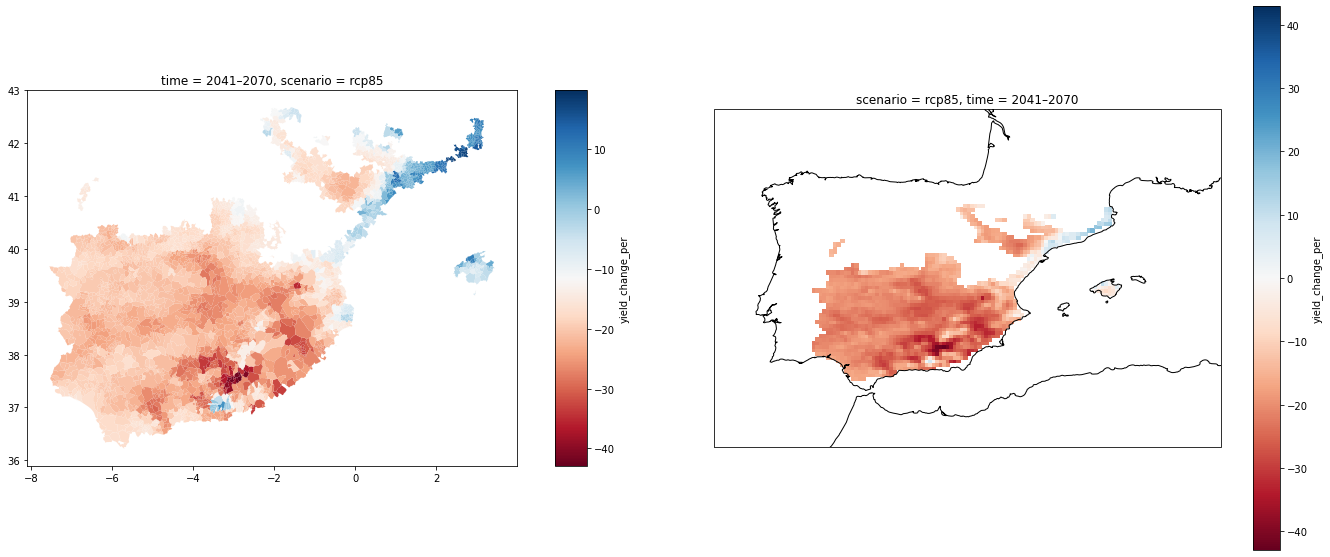

In [246]:
geometry = 'Municipios'

utils.display_figures(gdf_indicators, gdf_vectors, gdf_ids, geometry, ds_rasters, dataset, indicator, scenario, year, bbox, cmap='RdBu')

**Save tables**

In [252]:
for gdf_name in gdf_indicators.keys():
    name = gdf_name.lower().replace(' ', '_')
    gdf_indicators[gdf_name].to_csv(f'../../datasets/processed/olive_grove_indicators/olive_grove_indicators_{name}.csv', index = False)